<h1><center>HuBMAP: Hacking the Kidney - Training and Inference</center></h1>
<h2><center>Revised for DL Project</center></h2>

# Pytorch Modelling GPU Offline

Source: https://www.kaggle.com/vineeth1999/hubmap-pytorch-efficientunet-offline/

We are using **pytorch** implementation of **UNet** Model implemented in **https://github.com/qubvel/segmentation_models.pytorch** and this is getting installed offline.

## Necessary Imports

In [8]:
REDUCED_SET = False

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/DLProjectData/hubmap_train_256.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/masks/afa5e8098_0815.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0815.png  
  inflating: /content/masks/afa5e8098_0801.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0801.png  
  inflating: /content/masks/b2dc8411c_0193.png  
  inflating: /content/__MACOSX/masks/._b2dc8411c_0193.png  
  inflating: /content/masks/c68fe75ea_0281.png  
  inflating: /content/__MACOSX/masks/._c68fe75ea_0281.png  
  inflating: /content/masks/095bf7a1f_0482.png  
  inflating: /content/__MACOSX/masks/._095bf7a1f_0482.png  
  inflating: /content/masks/cb2d976f4_1151.png  
  inflating: /content/__MACOSX/masks/._cb2d976f4_1151.png  
  inflating: /content/masks/4ef6695ce_1720.png  
  inflating: /content/__MACOSX/masks/._4ef6695ce_1720.png  
  inflating: /content/masks/afa5e8098_0154.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0154.png  
  inflating: /content/masks/b9a3865fc_0380.png  
  inflating: /content/__MACO

In [6]:
!pip install albumentations==0.4.6
!pip install segmentation-models-pytorch

     |████████████████████████████████| 122kB 4.0MB/s 
     |████████████████████████████████| 952kB 15.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=93d55f38106f6704734c329a182ec6e1c6d0da02ec2a2d37b788273de40f8814
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 71kB 2.8MB/s 
     |████████████████████████████████| 245kB 5.2MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=7aaf4b31cc0b955e3ef4b79fb8e21d2ea0f80aa

In [9]:
from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage.interpolation import zoom
import albumentations as A
from torch.nn import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import zipfile
import time
import random
import albumentations.pytorch

from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch.unet import Unet
from tqdm.notebook import tqdm

## Hyperparameters & Config

In [10]:
num_epochs = 7
FOLDS = 5
learning_rate = 5e-4
train_batch_size = 16
val_batch_size = 16
num_workers = 0 # windows, for train_loader

images_path = "/content/train"

masks_path = "/content/masks"

seed = 42

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)

## Dataset

In [12]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with bug fix
def rle_encode_less_memory(img):
    #watch out for the bug
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [13]:
class HuBMAPDataset(Dataset):
    def __init__(self, ids, phase):
        self.ids = ids
        if phase=='train':
            self.transform = get_train_transform()
        else:
            self.transform = get_val_transform()
        
    def __getitem__(self, idx):
        name = self.ids[idx]
        img = cv2.imread(os.path.join(images_path, name)).astype("float32")[:,:,::-1] # changed path
        img /= 255.
        mask = cv2.imread(os.path.join(masks_path, name))[:,:,0:1] # changed path

        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        img = img.transpose(2,0,1).astype('float32')
        mask = mask.transpose(2,0,1).astype('float32')
        return img, mask

    def __len__(self):
        return len(self.ids)

        
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(),
            A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.3),
            A.OneOf([
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                A.GridDistortion(),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            A.ShiftScaleRotate(p=0.2),
            A.Resize(256,256,always_apply=True),
    ],p=1.)

def get_val_transform():
    return A.Compose([
        A.Resize(256,256,always_apply=True),
    ],p=1.)

## DataLoader

In [14]:
directory_list = os.listdir(images_path) # changed path
dir_df = pd.DataFrame(directory_list, columns=['Image_Paths'])

In [15]:
if REDUCED_SET:
    reduced_stem = ['e79de561c', '54f2eec69', 'c68fe75ea', 'afa5e8098', '4ef6695ce', '2f6ecfcdf', 'aaa6a05cc', 'cb2d976f4']
    #reduced_stem = ['e79de561c', '54f2eec69', 'c68fe75ea', 'aaa6a05cc']
    reduced_list = []

    reduced_dict = dict(zip(reduced_stem, [0] * len(reduced_stem)))
    print(reduced_dict)

    for img_path in directory_list:
        for reduced_name in reduced_stem:
            if reduced_name in img_path:
                reduced_list.append(img_path)
                reduced_dict[reduced_name] += 1

    print(len(directory_list))
    print(reduced_dict)
    print(len(reduced_list))

    # reduced dir_df
    dir_df = pd.DataFrame(reduced_list, columns=['Image_Paths'])

In [16]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df.loc[~df.Folds.isin(fold), "Image_Paths"].values
    val_ids = df.loc[df.Folds.isin(fold), "Image_Paths"].values
    train_ds = HuBMAPDataset(train_ids, "train")
    val_ds = HuBMAPDataset(val_ids, "val")
    train_loader = DataLoader(train_ds, batch_size=train_batch_size, pin_memory=True, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=val_batch_size, pin_memory=True, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

## Model

In [17]:
class HuBMAP(nn.Module):
    def __init__(self):
        super(HuBMAP, self).__init__()
        #self.cnn_model = Unet('efficientnet-b5', encoder_weights="imagenet", classes=1, activation=None)
        self.cnn_model = Unet('mobilenet_v2', encoder_weights=None, classes=1, activation=None) 
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    
    def forward(self, imgs):
        img_segs = self.cnn_model(imgs)
        return img_segs

## Loss Function

<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/80f87a71d3a616a0939f5360cec24d702d2593a2'>

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice


def getDiceScore(y_hat, y, smooth=1e-8):
    assert(y_hat.shape == y.shape)

    #comment out if your model contains a sigmoid or equivalent activation layer
    y_hat = torch.sigmoid(y_hat)
    
    #flatten label and prediction tensors
    y_hat = y_hat.view(-1)
    y_hat = (y_hat >= 0.5).float()
    y = y.view(-1)
    
    intersection = (y_hat * y).sum()                            
    dice = (2.*intersection + smooth)/(y_hat.sum() + y.sum() + smooth)  
    
    return dice.item()
    
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()

In [19]:
# def dice_coef_metric(probabilities: torch.Tensor,
#                      truth: torch.Tensor,
#                      treshold: float = 0.5,
#                      eps: float = 1e-9) -> np.ndarray:
#     """
#     Calculate Dice score for data batch.
#     Params:
#         probobilities: model outputs after activation function.
#         truth: truth values.
#         threshold: threshold for probabilities.
#         eps: additive to refine the estimate.
#         Returns: dice score aka f1.
#     """
#     scores = []
#     num = probabilities.shape[0]
#     predictions = (probabilities >= treshold).float()
#     assert(predictions.shape == truth.shape)
#     for i in range(num):
#         prediction = predictions[i]
#         truth_ = truth[i]
#         intersection = 2.0 * (truth_ * prediction).sum()
#         union = truth_.sum() + prediction.sum()
#         if truth_.sum() == 0 and prediction.sum() == 0:
#             scores.append(1.0)
#         else:
#             scores.append((intersection + eps) / union)
#     return np.mean(scores)

## Train Function

In [20]:
def HuBMAPLoss(images, targets, model, device):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    criterion = DiceBCELoss()
    loss = criterion(outputs, targets)
    return loss, outputs

In [21]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    dice_epoch = []
    for step, (images, targets) in enumerate(trainloader):
        # run model and get loss
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            #scheduler.step()
            optimizer.zero_grad()
        
        loss = loss.detach().item()
        total_loss += loss

        # get dice score
        dice_batch = getDiceScore(outputs, targets.to(device))
        dice_epoch.append(dice_batch)
            
    # print stuff
    print(
            f'epoch {epoch}, ' + \
            f'loss: {total_loss/len(trainloader):.4f}, ' + \
            f'time: {(time.time() - t):.4f}, '  + \
            f'dice: {np.mean(dice_epoch)}', end='\n'
        )
    return total_loss/len(trainloader), np.mean(dice_epoch)


def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    dice_epoch = []
    for step, (images, targets) in enumerate(validloader):
        # run model and get loss
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        
        # if ((step+1)%4==0 or (step+1)==len(validloader)):
        #     scheduler.step(total_loss/len(validloader))

        # get dice score
        dice_batch = getDiceScore(outputs, targets.to(device))
        dice_epoch.append(dice_batch)

    # print stuff       
    print(
            f'epoch {epoch}, ' + \
            f'loss: {total_loss/len(trainloader):.4f}, ' + \
            f'time: {(time.time() - t):.4f}, '  + \
            f'dice: {np.mean(dice_epoch)}', end='\n'
        )
    return total_loss/len(validloader), np.mean(dice_epoch)

## Creating Folds Column

In [22]:
#FOLDS = 5 # moved to hyperparams
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold

<h3>Helper</h3>

In [23]:
def timer(msg, reset = False):
    now = time.time();
    if not hasattr(timer, "start") or reset:
        timer.start = now;
        diff = 0;
    else:
        diff = now - timer.start;
        
    print(f"{msg} | {diff} seconds");

## The Real Training

In [24]:
train_loss_per_epoch = []
train_score_per_epoch = []

valid_loss_per_epoch = []
valid_score_per_epoch = []

# 1st entry is the train loss, 2nd entry is the valid loss, 3rd entry is the train dice score, 4th entry is the valid dice score
fold_dict = {}

In [25]:
timer("starting training", reset = True);
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    timer(f"{fold} fold loop")
    if fold>=1: # think this is just doing 1 cross validation ...
        break
        
    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = HuBMAP().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)
    
    
    for epoch in range(num_epochs):
        # train
        train_loss, train_score = train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        train_loss_per_epoch.append(train_loss)
        train_score_per_epoch.append(train_score)

        # validate
        with torch.no_grad():
            valid_loss, valid_score = valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
            valid_loss_per_epoch.append(valid_loss)
            valid_score_per_epoch.append(valid_score)
        
    fold_dict[fold] = (train_loss_per_epoch, valid_loss_per_epoch, train_score_per_epoch, valid_score_per_epoch)

    train_loss_per_epoch = []
    train_score_per_epoch = []
    valid_loss_per_epoch = []
    valid_score_per_epoch = []
    
    # save state per fold
    torch.save(model.state_dict(), f'FOLD-{fold}-model.pth')

    timer(f"{fold} done fold")

starting training | 0 seconds
0 fold loop | 0.03984546661376953 seconds
epoch 0, loss: 0.3751, time: 119.0418, dice: 0.014337594297290267
epoch 0, loss: 0.0496, time: 11.8961, dice: 0.15520478042113411
epoch 1, loss: 0.1337, time: 120.0766, dice: 0.40250575368399566
epoch 1, loss: 0.0260, time: 12.0109, dice: 0.6023343507200479
epoch 2, loss: 0.0984, time: 121.3990, dice: 0.5726387528838728
epoch 2, loss: 0.0204, time: 11.9720, dice: 0.6289258613270552
epoch 3, loss: 0.0848, time: 121.2896, dice: 0.6296371090807222
epoch 3, loss: 0.0194, time: 11.8177, dice: 0.5846358871087577
epoch 4, loss: 0.0757, time: 120.6807, dice: 0.6740313494181366
epoch 4, loss: 0.0160, time: 11.8565, dice: 0.7383047204464674
epoch 5, loss: 0.0687, time: 119.1551, dice: 0.7035610214544612
epoch 5, loss: 0.0142, time: 11.8113, dice: 0.7637375087787708
epoch 6, loss: 0.0604, time: 119.2104, dice: 0.7462761214725763
epoch 6, loss: 0.0119, time: 11.7492, dice: 0.8112027607858181
0 done fold | 926.8294882774353 sec

In [26]:
import matplotlib.pyplot as plt

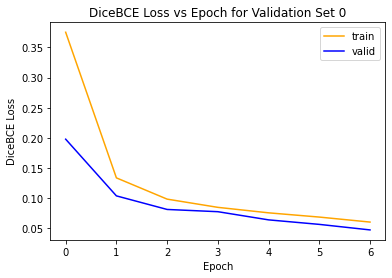

In [27]:
# loss score for epochs only

for i in range(1):
    plt.plot(fold_dict[i][0], label='train', color = 'orange')
    plt.plot(fold_dict[i][1], label='valid', color='blue')

    plt.xlabel('Epoch')
    plt.ylabel('DiceBCE Loss')

    plt.title("DiceBCE Loss vs Epoch for Validation Set {0}".format(i))
    plt.legend()
    plt.show()

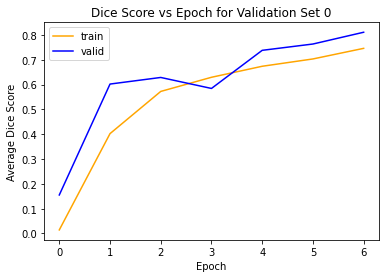

In [28]:
# dice score for epochs only

for i in range(1):
    plt.plot(fold_dict[i][2], label='train', color = 'orange')
    plt.plot(fold_dict[i][3], label='valid', color='blue')

    plt.xlabel('Epoch')
    plt.ylabel('Average Dice Score')

    plt.title("Dice Score vs Epoch for Validation Set {0}".format(i))
    plt.legend()
    plt.show()

In [29]:
# # loss for epochs only, using 2 axis

# for i in range(num_epochs):
#     fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
#     ax1.plot(fold_dict[i][0], label='train', color = 'orange')
#     ax2.plot(fold_dict[i][1], label='valid', color='blue')

#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Train Loss')
#     ax2.set_ylabel('Valid Loss')

#     plt.title("Loss vs Epoch for Validation Set {0}".format(i))
#     fig.legend()
#     plt.show()

In [30]:
# # dice score for epochs only, using 2 axis

# for i in range(num_epochs):
#     fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
#     ax1.plot(fold_dict[i][2], label='train', color = 'orange')
#     ax2.plot(fold_dict[i][3], label='valid', color='blue')

#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Train Dice Score')
#     ax2.set_ylabel('Valid Dice Score')

#     plt.title("Dice Score vs Epoch for Validation Set {0}".format(i))
#     fig.legend()
#     plt.show()